In [1]:
import sys
sys.path.append(r"/home/graham/Documents/Ironhack/Final-Project")
import src
import numpy as np

In [2]:
'''USING H20 TO FIND BETTER MODELS'''
import h2o
from h2o.automl import H2OAutoML

# Start H2O cluster
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,26 mins 09 secs
H2O_cluster_timezone:,Europe/Madrid
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.2
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_graham_zczj8m
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.845 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [3]:
path = ('/home/graham/Documents/Ironhack/Final-Project/data/combined_data.csv')
df = src.read_csv_file(path)


In [4]:
df = h2o.import_file(path)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [7]:
h2o.__version__

'3.40.0.2'

In [38]:
from h2o.grid.grid_search import H2OGridSearch
from h2o.estimators.random_forest import H2ORandomForestEstimator

target_col = '2022 Inf'
train, valid = df.split_frame(ratios=[0.7], seed=42)

# Define the hyperparameters to search over
hyper_params = {
    'ntrees': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_rows': [1, 2, 5],
    'mtries': [2, 4, 6],
    'sample_rate': [0.7, 0.8, 0.9],
    'col_sample_rate_per_tree': [0.7, 0.8, 0.9],
    'min_split_improvement': [1e-4, 1e-5, 1e-6]
}


# Create a grid search object
rf_grid = H2OGridSearch(
    model=H2ORandomForestEstimator,
    grid_id='rf_grid',
    hyper_params=hyper_params,
    search_criteria={'strategy': 'RandomDiscrete', 'max_models': 10, 'seed': 42}
)

# Train the grid search object
rf_grid.train(x=train.names[:-1], y=train.names[-1], training_frame=train, validation_frame=valid)

drf Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%


,max_depth,min_rows,ntrees,model_ids,residual_deviance
,20.0,1.0,300.0,rf_grid_model_59,0.1226311
,30.0,1.0,300.0,rf_grid_model_53,0.1273672
,10.0,2.0,300.0,rf_grid_model_55,0.1934141
,20.0,5.0,300.0,rf_grid_model_57,0.2752037
,20.0,5.0,100.0,rf_grid_model_52,0.3362811
,10.0,1.0,200.0,rf_grid_model_51,0.3683120
,20.0,5.0,300.0,rf_grid_model_58,0.3907682
,30.0,5.0,100.0,rf_grid_model_60,0.4128769
,30.0,1.0,200.0,rf_grid_model_54,0.5174589
,10.0,2.0,300.0,rf_grid_model_56,0.5765567


In [39]:
best_model = rf_grid.models[0]
if best_model.model_performance(valid=True) is not None:
    r2 = best_model.r2(valid=True)
    print(f"Best model: (R-squared: {r2:.4f})")
else:
    print("Best model has no validation data.")


Best model: (R-squared: 0.9892)


In [40]:
# Use the best model for prediction
predictions = best_model.predict(valid)
# Calculate R-squared on the test set
r2 = best_model.r2(valid=True)
print(f"R-squared: {r2:.4f}")

# Calculate MAE on the test set
mae = best_model.mae(valid=True)
print(f"MAE: {mae:.4f}")

# Calculate RMSE on the test set
rmse = best_model.rmse(valid=True)
print(f"RMSE: {rmse:.4f}")

# Calculate MAPE on the test set
actuals = valid[target_col].as_data_frame().values.flatten()
preds = predictions['predict'].as_data_frame().values.flatten()
mape = np.mean(np.abs((actuals - preds) / actuals)) * 100
print(f"MAPE: {mape:.2f}%")


drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
R-squared: 0.9892
MAE: 0.2834
RMSE: 0.3502
MAPE: 81.82%


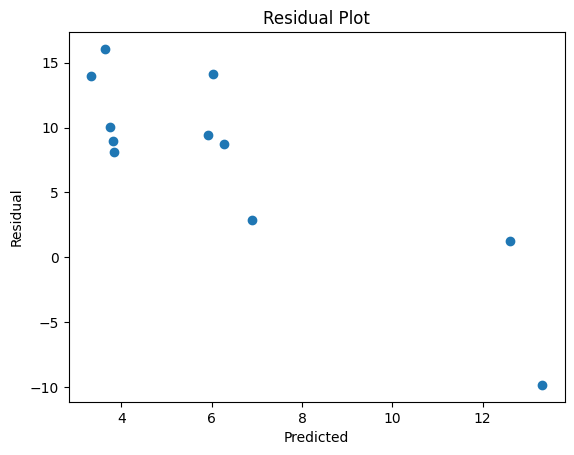

In [36]:
import matplotlib.pyplot as plt

# Get the actual target values for the validation set
y_true = valid[target_col].as_data_frame().values

# Get the predicted target values for the validation set
y_pred = predictions['predict'].as_data_frame().values

# Calculate the residuals
residuals = y_true - y_pred

# Create a scatter plot of the residuals
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.title('Residual Plot')
plt.savefig('/home/graham/Documents/Ironhack/Final-Project/images/residuals2.png', bbox_inches='tight')
plt.show()

In [32]:
df['2023 inflation'] = np.nan
predictions = best_model.predict(df)
df['2023 inflation'] = predictions['predict']

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


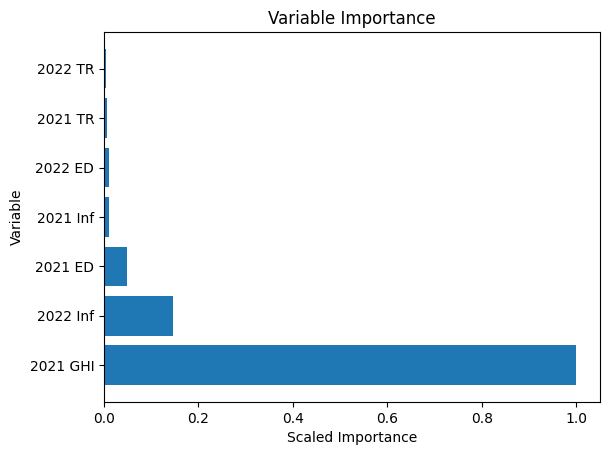

In [34]:
import matplotlib.pyplot as plt
feat_imp = best_model.varimp(use_pandas=True)
plt.barh(feat_imp['variable'], feat_imp['scaled_importance'])
plt.title('Variable Importance')
plt.xlabel('Scaled Importance')
plt.ylabel('Variable')
plt.savefig('/home/graham/Documents/Ironhack/Final-Project/images/feature2.png', bbox_inches='tight')

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


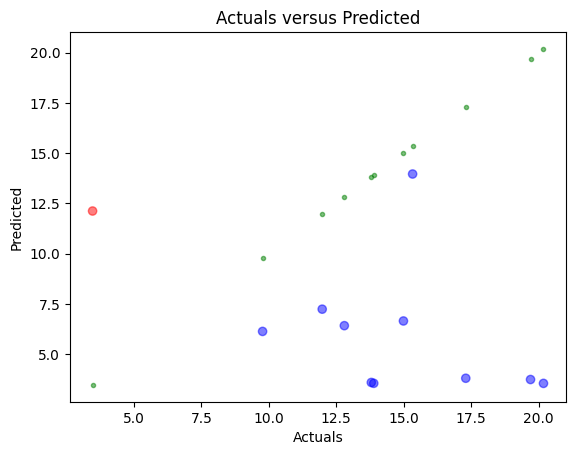

In [42]:
predictions = best_model.predict(valid)

# Add the predicted inflation for the next year to the predictions frame
predictions = predictions.cbind(valid["2023 inflation"])

# Extract the actual and predicted values
actuals = valid[target_col].as_data_frame().values.flatten()
predicted = predictions["predict"].as_data_frame().values.flatten()
valid_indices = valid.as_data_frame().index.values
actuals = actuals[valid_indices - 1]  # adjust indices to 0-based indexing
residuals = actuals - predicted
abs_residuals = np.abs(residuals)

# Define the colors for the data points
colors = np.where(residuals >= 0, 'b', 'r')  # blue for under-predictions, red for over-predictions
colors = np.array(colors).flatten()
# Plot the residuals against the actual values with colored data points
plt.scatter(actuals, predicted, c=colors, alpha=0.5)
plt.scatter(actuals, actuals, c='g', marker='.', alpha=0.5)
plt.xlabel('Actuals')
plt.ylabel('Predicted')
plt.title('Actuals versus Predicted')
plt.savefig('/home/graham/Documents/Ironhack/Final-Project/images/AvP3.png', bbox_inches='tight')
plt.show()